In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
dataset = load_dataset("Falah/Alzheimer_MRI")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-c08a401c53fe53(…):   0%|          | 0.00/22.6M [00:00<?, ?B/s]

data/test-00000-of-00001-44110b9df98c558(…):   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})

In [4]:
label_names = {
    0: "MildDemented",
    1: "ModerateDemented",
    2: "NonDemented",
    3: "VeryMildDemented"
}

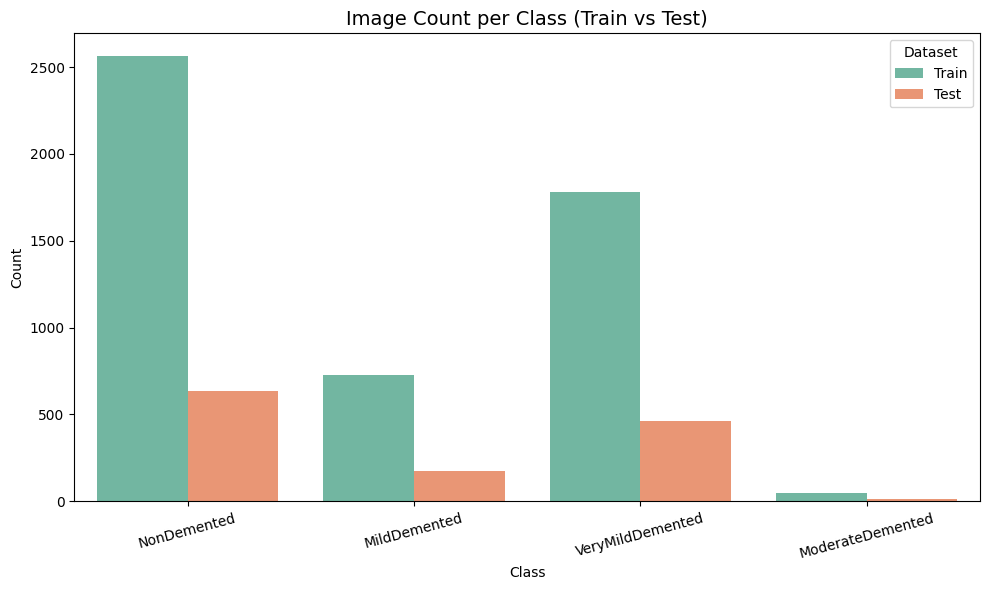

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

train_counts = Counter(dataset['train']['label'])
test_counts = Counter(dataset['test']['label'])


df_train = pd.DataFrame({'Class': [label_names[i] for i in train_counts.keys()],
                         'Count': train_counts.values(),
                         'Dataset': 'Train'})

df_test = pd.DataFrame({'Class': [label_names[i] for i in test_counts.keys()],
                        'Count': test_counts.values(),
                        'Dataset': 'Test'})

df_all = pd.concat([df_train, df_test])

plt.figure(figsize=(10,6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_all, palette='Set2')
plt.title("Image Count per Class (Train vs Test)", fontsize=14)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

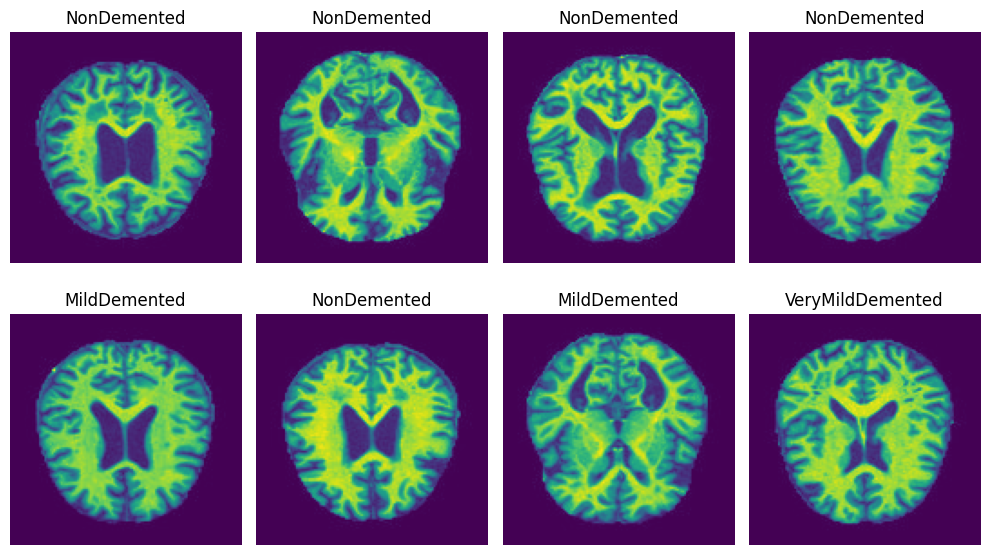

In [6]:
import random

plt.figure(figsize=(10,6))
for i in range(8):
    sample = random.choice(dataset['train'])
    img = sample['image']
    label = label_names[sample['label']]
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
train_valid_split = dataset['train'].train_test_split(test_size=0.10, seed=42)
train_hf = train_valid_split['train']
val_hf   = train_valid_split['test']
test_hf  = dataset['test']

print("HF sizes -> train:", len(train_hf), "val:", len(val_hf), "test:", len(test_hf))

print("Train counts:", Counter(train_hf['label']))
print("Val counts:  ", Counter(val_hf['label']))
print("Test counts: ", Counter(test_hf['label']))

HF sizes -> train: 4608 val: 512 test: 1280
Train counts: Counter({2: 2313, 3: 1612, 0: 644, 1: 39})
Val counts:   Counter({2: 253, 3: 169, 0: 80, 1: 10})
Test counts:  Counter({2: 634, 3: 459, 0: 172, 1: 15})


In [8]:
from torch.utils.data import Dataset

class HFDatasetTorch(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item['image']

        if hasattr(img, "mode"):
            if img.mode != "RGB":
                img = img.convert("RGB")
        else:

            from PIL import Image
            img = Image.fromarray(img).convert("RGB")

        label = int(item['label'])
        if self.transform:
            img = self.transform(img)
        return img, label

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from datasets import load_dataset
import numpy as np
from PIL import Image
import random
from collections import Counter
import time
import copy

In [10]:
import torchvision.transforms as T

IMG_SIZE = 224
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [11]:
BATCH_SIZE = 32
num_workers = 2
train_ds = HFDatasetTorch(train_hf, transform=train_transforms)
val_ds   = HFDatasetTorch(val_hf, transform=val_test_transforms)
test_ds  = HFDatasetTorch(test_hf, transform=val_test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [12]:
batch = next(iter(train_loader))
imgs, labels = batch
print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [13]:
# ResNet18 transfer learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(label_names)

model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 96.3MB/s]


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        since = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total += inputs.size(0)

            epoch_loss = running_loss / total
            epoch_acc  = running_corrects / total
            print(f"  {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch time: {time.time()-since:.1f}s\n")

    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

In [15]:
NUM_EPOCHS = 5
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

torch.save(model.state_dict(), "best_resnet18_alzheimers.pth")
print("Saved best_resnet18_alzheimers.pth")

Epoch 1/5
  train Loss: 0.8618 Acc: 0.6276
  val Loss: 0.7668 Acc: 0.6387
Epoch time: 22.5s

Epoch 2/5
  train Loss: 0.6012 Acc: 0.7485
  val Loss: 0.5999 Acc: 0.7500
Epoch time: 20.2s

Epoch 3/5
  train Loss: 0.4140 Acc: 0.8372
  val Loss: 0.5432 Acc: 0.7891
Epoch time: 20.8s

Epoch 4/5
  train Loss: 0.2844 Acc: 0.8924
  val Loss: 0.4445 Acc: 0.8281
Epoch time: 20.5s

Epoch 5/5
  train Loss: 0.2179 Acc: 0.9214
  val Loss: 0.2071 Acc: 0.9102
Epoch time: 20.7s

Best val Acc: 0.9102
Saved best_resnet18_alzheimers.pth


In [16]:
def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    total = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)
            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(labels.cpu().tolist())
    acc = running_corrects / total
    return acc, preds_all, labels_all

test_acc, preds, labels = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9156


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
cm = confusion_matrix(labels, preds)
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(labels, preds, target_names=[label_names[i] for i in range(num_classes)]))

Confusion matrix:
 [[152   0   4  16]
 [  0  13   0   2]
 [  4   0 609  21]
 [ 19   0  42 398]]
Classification report:
                   precision    recall  f1-score   support

    MildDemented       0.87      0.88      0.88       172
ModerateDemented       1.00      0.87      0.93        15
     NonDemented       0.93      0.96      0.94       634
VeryMildDemented       0.91      0.87      0.89       459

        accuracy                           0.92      1280
       macro avg       0.93      0.89      0.91      1280
    weighted avg       0.92      0.92      0.92      1280



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import cv2
import os
import torch
import torchvision.transforms as T

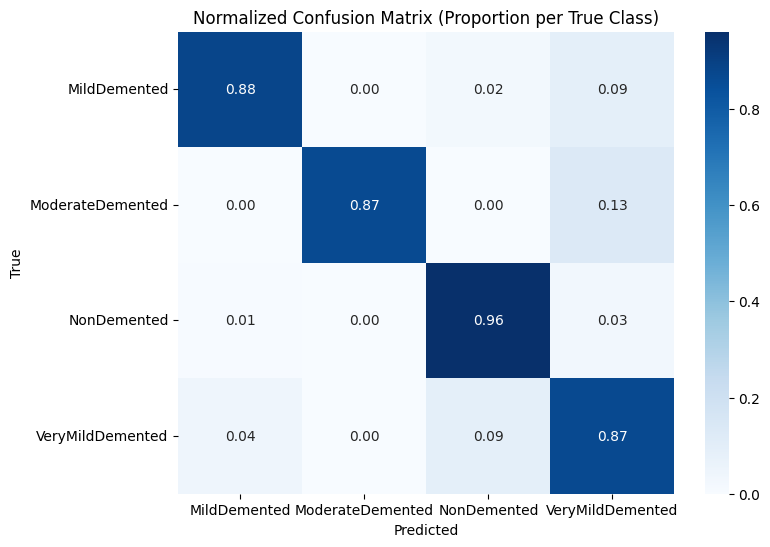

In [19]:
cm = confusion_matrix(labels, preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=[label_names[i] for i in range(len(label_names))],
            yticklabels=[label_names[i] for i in range(len(label_names))], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Proportion per True Class)')
plt.show()

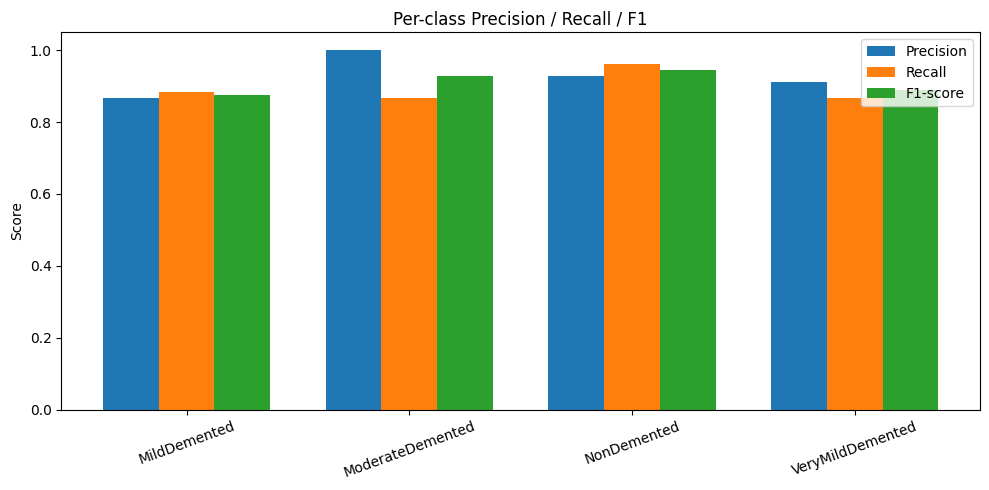

In [20]:
prec, rec, f1, sup = precision_recall_fscore_support(labels, preds, labels=list(range(len(label_names))))
classes = [label_names[i] for i in range(len(label_names))]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, classes, rotation=20)
plt.ylim(0,1.05)
plt.ylabel('Score')
plt.title('Per-class Precision / Recall / F1')
plt.legend()
plt.tight_layout()
plt.show()

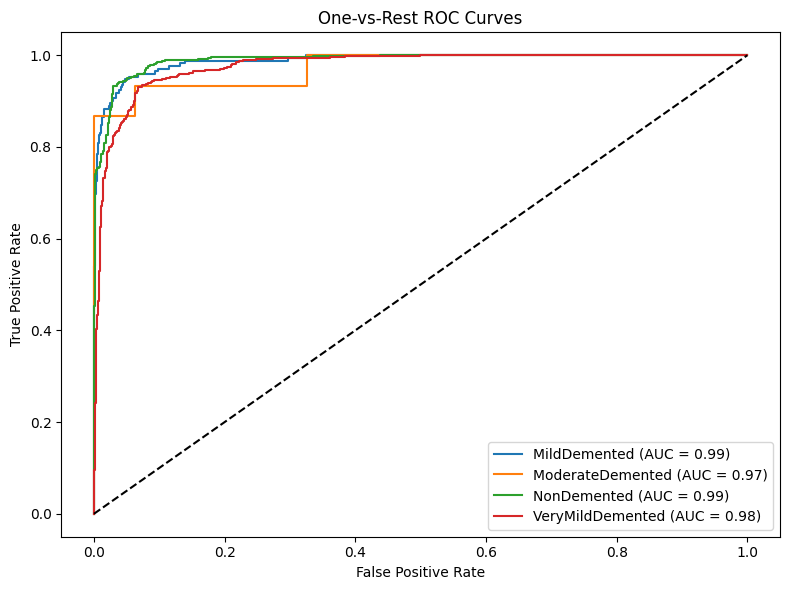

In [21]:
model.eval()
probs_all = []
labels_all = []
with torch.no_grad():
    for inputs, labs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        probs_all.append(probs)
        labels_all.extend(labs.numpy().tolist())
probs_all = np.vstack(probs_all)
y_true = np.array(labels_all)
n_classes = len(label_names)
y_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


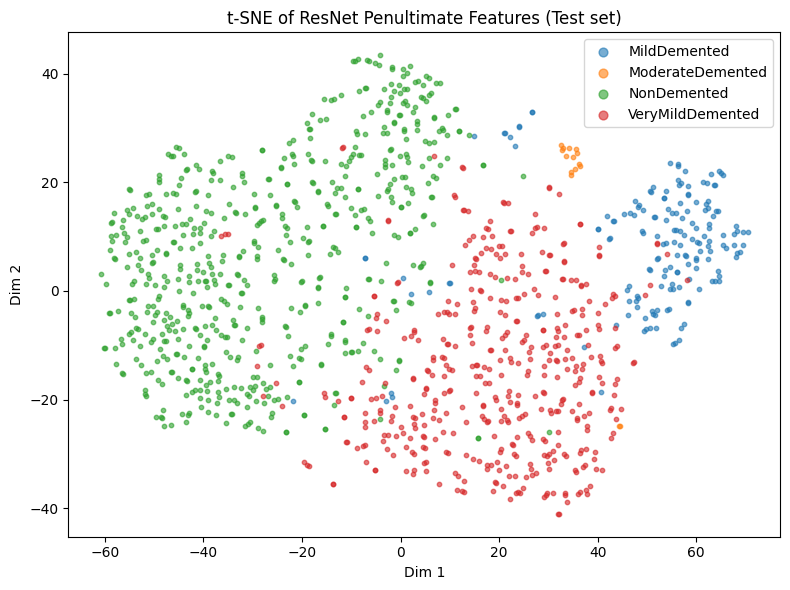

In [22]:
model.eval()
features = []
labels_feats = []
with torch.no_grad():
    for inputs, labs in test_loader:
        inputs = inputs.to(device)
        x = model.conv1(inputs)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        features.append(x.cpu().numpy())
        labels_feats.extend(labs.numpy().tolist())

features = np.vstack(features)
labels_feats = np.array(labels_feats)

sample_n = 2000
if features.shape[0] > sample_n:
    idx = np.random.choice(features.shape[0], sample_n, replace=False)
    feat_sample = features[idx]
    lab_sample = labels_feats[idx]
else:
    feat_sample = features
    lab_sample = labels_feats

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
emb = tsne.fit_transform(feat_sample)

plt.figure(figsize=(8,6))
for i, cname in enumerate([label_names[i] for i in range(n_classes)]):
    mask = lab_sample == i
    plt.scatter(emb[mask,0], emb[mask,1], label=cname, alpha=0.6, s=10)
plt.legend(markerscale=2)
plt.title('t-SNE of ResNet Penultimate Features (Test set)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.tight_layout()
plt.show()

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        def save_grad(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        def save_activation(module, input, output):
            self.activations = output.detach()


        target_layer.register_forward_hook(save_activation)
        target_layer.register_full_backward_hook(save_grad)

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[0, class_idx]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0,2,3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = torch.sum(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= (heatmap.max() + 1e-8)
        return heatmap, class_idx

target_layer = model.layer4
gcam = GradCAM(model, target_layer)

print("Grad-CAM object created")

Grad-CAM object created


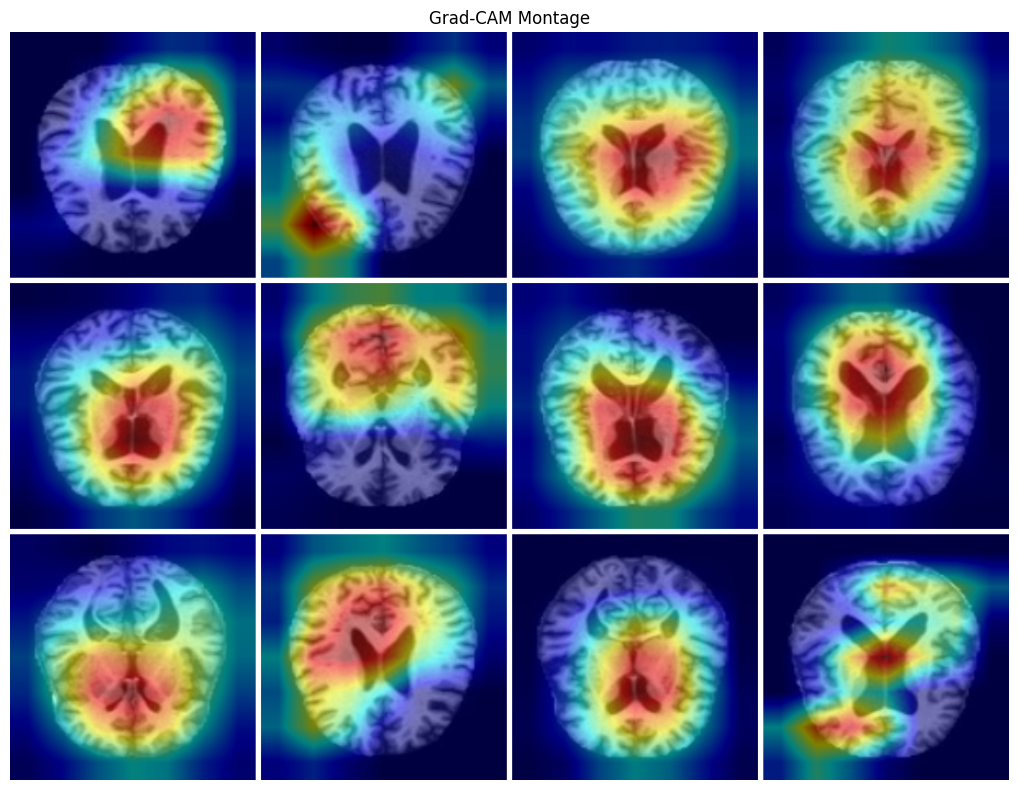

Saved: gradcam_montage/gradcam_montage.png


In [24]:
def generate_gradcam_overlay(inp_tensor, gcam):
    heatmap, pred_class = gcam(inp_tensor.to(device), None)
    inv_norm = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_norm(inp_tensor[0].cpu()).clamp(0,1)
    img_np = np.uint8(255 * img.permute(1,2,0).numpy())
    hmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    hmap_uint = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap_uint, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(hmap_color, 0.5, img_np[..., ::-1], 0.5, 0)
    overlay = overlay[..., ::-1]
    return overlay, pred_class

import os
os.makedirs("gradcam_montage", exist_ok=True)

imgs_collected = []
titles = []
N = 12
count = 0
for inputs, labs in test_loader:
    for i in range(inputs.size(0)):
        inp = inputs[i].unsqueeze(0)
        overlay, pred = generate_gradcam_overlay(inp, gcam)
        imgs_collected.append(overlay)
        titles.append(f"T:{label_names[labs[i].item()]}|P:{label_names[pred]}")
        count += 1
        if count >= N:
            break
    if count >= N:
        break

rows, cols = 3, 4
h, w, _ = imgs_collected[0].shape
montage = np.ones((rows*h + (rows-1)*5, cols*w + (cols-1)*5, 3), dtype=np.uint8)*255
k = 0
for r in range(rows):
    for c in range(cols):
        if k >= len(imgs_collected): break
        r0, c0 = r*(h+5), c*(w+5)
        montage[r0:r0+h, c0:c0+w] = imgs_collected[k]
        k += 1

plt.figure(figsize=(12,8))
plt.imshow(montage)
plt.axis('off')
plt.title('Grad-CAM Montage')
plt.tight_layout()
plt.savefig("gradcam_montage/gradcam_montage.png", bbox_inches='tight')
plt.show()
print("Saved: gradcam_montage/gradcam_montage.png")

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # global average pooling approach (faster than flatten large tensors)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [27]:
model = SimpleCNN(num_classes=4).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=4, bias=True)
)


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_val_acc = 0.0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_scratch_cnn.pth")

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs

In [30]:
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch 1/5 | Train Loss: 0.9412, Acc: 0.5395 | Val Loss: 1.3399, Acc: 0.5020
Epoch 2/5 | Train Loss: 0.9162, Acc: 0.5551 | Val Loss: 1.0251, Acc: 0.5195
Epoch 3/5 | Train Loss: 0.9124, Acc: 0.5577 | Val Loss: 1.0125, Acc: 0.5352
Epoch 4/5 | Train Loss: 0.9123, Acc: 0.5592 | Val Loss: 1.1130, Acc: 0.5059
Epoch 5/5 | Train Loss: 0.9081, Acc: 0.5636 | Val Loss: 1.0900, Acc: 0.5059
Best Validation Accuracy: 0.5352


In [31]:
model.load_state_dict(torch.load("best_scratch_cnn.pth"))
model.eval()

correct, total = 0, 0
preds_all, labels_all = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"Test Accuracy (Scratch CNN): {test_acc:.4f}")

Test Accuracy (Scratch CNN): 0.5383


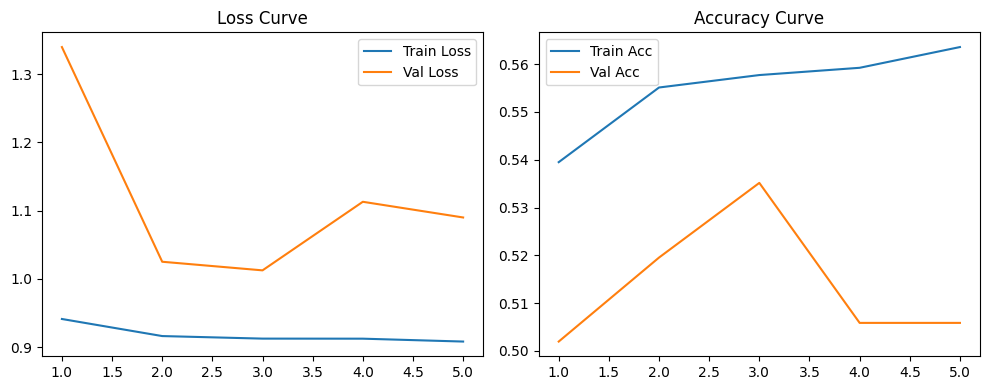

In [32]:
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.legend(); plt.title("Accuracy Curve")
plt.tight_layout()
plt.show()